# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [128]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline

In [129]:
def remove_seam(image, seam):
    H, W, C = image.shape
    output = np.zeros((H, W-1, C), dtype=image.dtype)
    for i in range(H):
        j = seam[i]
        output[i, :, :] = np.delete(image[i, :, :], j, axis=0)
    return output

def seam_carving(image, seams_number, depth_map=None, saliency_map=None, visualize=False):
    image = image.copy()
    seam_energies = []

    for n in range(seams_number):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
        E = np.abs(gx) + np.abs(gy)

        H, W = gray.shape
        if depth_map is not None:
            depth_map_resized = cv2.resize(depth_map, (W, H))
            E += depth_map_resized
        if saliency_map is not None:
            saliency_map_resized = cv2.resize(saliency_map, (W, H))
            E += saliency_map_resized

        M = E.copy()
        backtrack = np.zeros_like(M, dtype=np.int32)
        
        for i in range(1, H):
            for j in range(W):
                if j == 0:
                    idx = np.argmin(M[i-1, j:j+2])
                    backtrack[i, j] = idx
                    M[i, j] += M[i-1, j+idx]
                elif j == W-1:
                    idx = np.argmin(M[i-1, j-1:j+1])
                    backtrack[i, j] = idx - 1
                    M[i, j] += M[i-1, j-1+idx]
                else:
                    idx = np.argmin(M[i-1, j-1:j+2])
                    backtrack[i, j] = idx - 1
                    M[i, j] += M[i-1, j-1+idx]

        seam = np.zeros(H, dtype=int)
        j = np.argmin(M[-1])
        seam[-1] = j
        for i in range(H-2, -1, -1):
            j += backtrack[i+1, j]
            seam[i] = j

        seam_energies.append(M[-1, seam[-1]])

        if visualize and n == seams_number-1:
            img_vis = image.copy()
            for i_row in range(H):
                img_vis[i_row, seam[i_row], :] = [1, 0, 0] 
            plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        image = remove_seam(image, seam)

    return image, seam_energies

In [130]:
# Load images and maps
baby_path = r'C:\Users\hashe\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby.png'
baby_dmap_path = r'C:\Users\hashe\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby_DMap.png'
baby_smap_path = r'C:\Users\hashe\techstack2025-ai\week3\task\part2_CAIR\images\Baby\Baby_SMap.png'

baby = cv2.imread(baby_path).astype(np.float32) / 255.0
baby_dmap = cv2.imread(baby_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
baby_dmap = cv2.resize(baby_dmap, (baby.shape[1], baby.shape[0]))

baby_smap = cv2.imread(baby_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
baby_smap = cv2.resize(baby_smap, (baby.shape[1], baby.shape[0]))


# Parameters
seams_number = 20
visualize = True

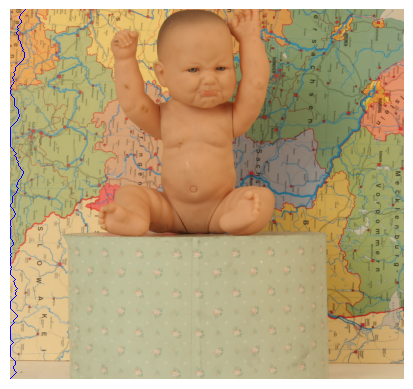

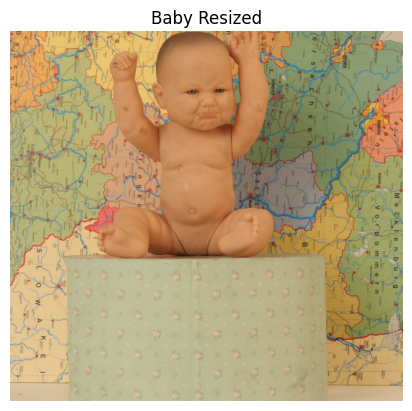

True

In [131]:
# Process images
baby_resized, baby_energies = seam_carving(baby, seams_number, baby_dmap, baby_smap, visualize)

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Baby Seam Energies:\\n' + '\\n'.join(map(str, baby_energies)) + '\\n')

# Visualize results
plt.imshow(cv2.cvtColor(baby_resized, cv2.COLOR_BGR2RGB))
plt.title('Baby Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('Baby_resized.png', (baby_resized * 255).astype(np.uint8))